In [1]:
import py_wgpu_fdm
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation


In [2]:
d = 1e-3
D = 5e-3 
L = 1.2
node_count = 480
turns = 960

r = (D + d)/2
p = L / (turns * 2 * np.pi)

kappa = r / (r**2 + p**2)
tau = p / (r**2 + p**2)

S = 2.0 * np.pi * turns * np.sqrt(r**2 + p**2)

ds = S / ( node_count - 1 )
dx = L / ( node_count - 1 )
dx2 = dx * dx





print(f"Curvature κ: {kappa:.3e} 1/m")
print(f"Torsion τ: {tau:.3e} 1/m")
print(f"Wire length S: {S:.3f} m")
print(f"Helix delta: {ds:.3f} m")
print(f"Core delta: {dx:.3f} m")

Curvature κ: 3.319e+02 1/m
Torsion τ: 2.201e+01 1/m
Wire length S: 18.135 m
Helix delta: 0.038 m
Core delta: 0.003 m


In [3]:
dt = 1.0e-8


(1/dt)/(44_100 * 22)


103.07153164296021

In [4]:
def winding_properties(d, E, G, rho):

    r = d / 2
    A = np.pi * r**2
    I1 = I2 = (np.pi * r**4) / 4   # bending moments of inertia
    J = (np.pi * r**4) / 2         # polar moment of inertia for torsion

    # Radii of gyration
    k1 = np.sqrt(I1 / A)
    k2 = np.sqrt(I2 / A)
    kT = np.sqrt(J / A)

    # Flexural rigidities (bending about two axes) and torsional rigidity
    beta1 = E * I1
    beta2 = E * I2
    betaT = G * J

    # Shear rigidities (sigma1, sigma2) and extensional rigidity (sigma_p)
    sigma1 = G * A
    sigma2 = G * A
    sigma_p = E * A

    mass_per_length = rho * A

    return {
        'm': mass_per_length,
        'k': [k1, k2, kT],
        'beta': [beta1, beta2, betaT],
        'sigma': [sigma1, sigma2, sigma_p]
    }

def core_properties(D, T, rho):
        r = d / 2
        A = np.pi * r**2
        mass_per_length = rho * A
        c2 = T / mass_per_length
    
        return {
        'c2': c2,
        'm': mass_per_length,
    }

In [5]:
loss = 0.9999990
rho = 8900
rho_core = 8700
E=1.1e11
G=4.1e10
T=800

coil_props = winding_properties(d, E, G, rho)
core_props = core_properties(D, T, rho_core)


print(coil_props)
print(core_props)

{'m': 0.006990043654237289, 'k': [np.float64(0.00025000000000000006), np.float64(0.00025000000000000006), np.float64(0.0003535533905932738)], 'beta': [0.0053996123733574585, 0.0053996123733574585, 0.004025165587411924], 'sigma': [32201.324699295375, 32201.324699295375, 86393.79797371931]}
{'c2': 117079.49836645176, 'm': 0.006832964021557799}


In [6]:

# Create initial node data in local (u,v,w) helical frame
nodes = []
for i in range(node_count):
    position = [0.0, 0.0, 0.0]  # along tangent
    velocity = [0.0, 0.0, 0.0]
    angle = [0.0, 0.0, 0.0]
    angular_velocity = [0.0, 0.0, 0.0]
    
    nodes.append([position, velocity, angle, angular_velocity])



### Note to self

+ Each step advances by `dt`
+ Each `compute()` invocation runs `CHUNKSIZE * OVERSAMPLING FACTOR` steps.
+ The output has a sample_rate of `1/(dt * CHUNKSIZE)`

In [7]:
# We want (44_100 / CHUNK_SIZE) * DURATION invocations
T = 0.05 #time in seconds
chunk_size = 441
invocations = int((44_100 / chunk_size) * T)

# but each frame only yields time steps of dt seconds
# thusly, we need to oversample by a factor of
# dt^-1 / 44_100 times
total_os_factor = (1/dt) / 44_100
oversampling_factor = 23

steps = 1


ori_frames = []

total = oversampling_factor * invocations * T * chunk_size 
n_frames = chunk_size * invocations

print("Setting up simulation instance")

# Initialize simulation with given parameters
sim = py_wgpu_fdm.Simulation(
    nodes,
    oversampling_factor,
    dt,
    1/(2*ds),
    loss,
    tau,
    kappa,
    1/(coil_props['m'] + core_props['m']),
    core_props['c2'],
    coil_props['beta'],
    1/dx2,
    #[1, 1, 1],
    coil_props['sigma'],
    chunk_size,
    [1 / k**2 for k in coil_props['k']],
)

Setting up simulation instance


[py-wgpu-fdm/src/gpu_bindings.rs:376:9] &fdm_uniform = FDMUniform {
    dt: 1e-8,
    two_ds_inv: 13.206275,
    node_count: 480,
    loss: 0.999999,
    tau: 22.00807,
    kappa: 331.87387,
    m_inv: 72.343155,
    c2_core: 117079.5,
    beta: [
        0.0053996122,
        0.0053996122,
        0.0040251655,
    ],
    dx2_inv: 159334.03,
    sigma: [
        32201.324,
        32201.324,
        86393.8,
    ],
    chunk_size: 441,
    k_inv: [
        16000000.0,
        16000000.0,
        8000000.0,
    ],
    _padding5: 0,
}


In [8]:

print("Initializing simulation...")

# Run the initialization for 200 steps
sim.initialize(10)

print("Initial condition reached.")

Initializing simulation...
Calling GPU binding
Calling init!
Initial condition reached.


In [9]:
print(f'Running {total} steps, which is {total * dt} seconds. Generating {n_frames} output samples.') 


for i in range(invocations):
    sim.compute()
    frames = sim.save()
    for frame in frames:
        ori_frames.append(frame)

Running 2535.75 steps, which is 2.53575e-05 seconds. Generating 2205 output samples.
Transferring buffer with size 54190080
Transferring buffer with size 54190080
Transferring buffer with size 54190080
Transferring buffer with size 54190080
Transferring buffer with size 54190080


In [13]:
ori_frames[80]

[[[0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0]],
 [[0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0]],
 [[0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0]],
 [[0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0]],
 [[0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0]],
 [[0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0]],
 [[0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0

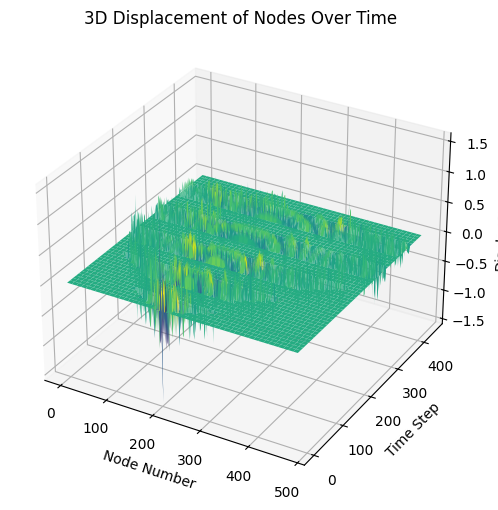

Frame count: 441


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assume frames is already defined as:
# frames[time_step][node_index][0][0] -> displacement value

frames = [ f for i,f in enumerate(ori_frames) if i % 10 == 0 ]


# Extract number of time steps and nodes
num_frames = len(frames)
num_nodes = len(frames[0])

# Build coordinate grids
time_steps = np.arange(num_frames)
node_indices = np.arange(num_nodes)
T, N = np.meshgrid(time_steps, node_indices, indexing='ij')

# Extract displacement values into a 2D array (time × nodes)
displacements = np.array([[frame[node][0][0] for node in range(num_nodes)] for frame in frames])

# Create 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(N, T, displacements, cmap='viridis', edgecolor='none')

# Axis labels
ax.set_xlabel('Node Number')
ax.set_ylabel('Time Step')
ax.set_zlabel('Displacement')

ax.set_title('3D Displacement of Nodes Over Time')

plt.show()
print(f'Frame count: {num_frames}')

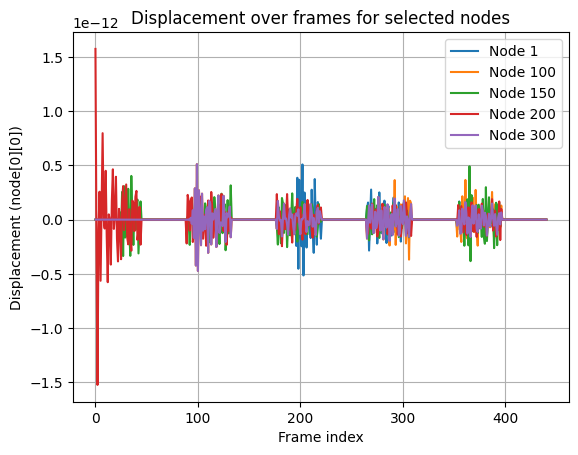

In [12]:
import matplotlib.pyplot as plt




indices = [ 1, 100, 150, 200, 300 ]

# Extract displacements
for i in indices:
    displacements = [frame[i][0][0] for frame in frames]
    plt.plot(range(len(frames)), displacements, label=f'Node {i}')

plt.xlabel('Frame index')
plt.ylabel('Displacement (node[0][0])')
plt.title('Displacement over frames for selected nodes')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import sounddevice as sd

def play_float_array(arr, duration=None):
    """
    Play a 1D numpy float array as audio.
    
    Parameters:
        arr : np.ndarray
            Float array with arbitrary range.
        duration : float or None
            Duration in seconds. If None, defaults to len(arr)/44100.
    """
    arr = np.asarray(arr, dtype=float)
    
    # Normalize to [-1, 1]
    max_val = np.max(np.abs(arr))
    if max_val > 0:
        arr = arr / max_val
    
    # Set sample rate to match duration
    if duration is None:
        samplerate = 1000000  # default
    else:
        samplerate = int(len(arr) / duration)
    
    # Convert to 16-bit PCM
    audio = np.int16(arr * 32767)
    
    # Play audio
    sd.play(audio, samplerate)
    sd.wait()

# Example usage:
# Generate a 1-second sine wave at 440 Hz
fs = 44100
t = np.linspace(0, 1, fs, endpoint=False)
signal = np.sin(2 * np.pi * 440 * t)

#play_float_array(signal)

node_disps = [ f[200][0] for f in frames ]

from scipy.signal import resample_poly
def downsample(audio, sr_in=1_000_000, sr_out=44_100):
    """
    Downsample an audio signal from sr_in to sr_out using polyphase filtering.
    
    audio : np.ndarray
        Input 1D signal.
    sr_in : int
        Original sample rate.
    sr_out : int
        Target sample rate.
    """
    # Compute integer up/down factors
    # You can also just pass sr_out, sr_in directly; SciPy handles ratios
    y = resample_poly(audio, sr_out, sr_in)
    return y

smpls = downsample(node_disps)
distances = np.linalg.norm(smpls, axis=1)

#play_float_array(distances)
#smpls
len(ori_frames)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
def frenet_to_cartesian(frames, alpha_deg):

    # Transformation matrix R
    R = np.array([
        [1, 0, 0],
        [0, np.cos(alpha), -np.sin(alpha)],
        [0, np.sin(alpha),  np.cos(alpha)]
    ])
    # Apply transformation to each frame
    cart_frames = frames @ R.T
    return cart_frames


def render_movie(displacements, ds=1.0, framerate=30, filename="3d_string.mp4"):
    """
    Animate a 3D string given node displacements.

    displacements: np.array of shape (num_frames, num_nodes, 3)
    ds: spacing along the string in z-direction
    """
    num_frames, num_nodes, _ = displacements.shape

    # Precompute the base z-coordinates along the string
    z_base = np.arange(num_nodes) * ds
    base_coords = np.zeros((num_nodes, 3))
    base_coords[:, 2] = z_base  # (x=0, y=0, z=z_base)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    line, = ax.plot([], [], [], '-', lw=1)

    # Compute limits
    all_coords = base_coords + displacements
    ax.set_xlim(np.min(all_coords[:,:,0]), np.max(all_coords[:,:,0]))
    ax.set_ylim(np.min(all_coords[:,:,1]), np.max(all_coords[:,:,1]))
    ax.set_zlim(np.min(all_coords[:,:,2]), np.max(all_coords[:,:,2]))

    def init():
        line.set_data([], [])
        line.set_3d_properties([])
        return line,

    def update(frame_idx):
        coords = base_coords + displacements[frame_idx]
        x = coords[:,0]
        y = coords[:,1]
        z = coords[:,2]
        line.set_data(x, y)
        line.set_3d_properties(z)
        return line,

    interval = 1000 / framerate
    ani = FuncAnimation(fig, update, frames=num_frames, init_func=init, blit=True, interval=interval)

    # Save animation
    writer = FFMpegWriter(fps=framerate)
    ani.save(filename, writer=writer)

    plt.show()
    return ani


    
alpha = np.arctan(p/r)
displacements = np.array([[frame[node][0] for node in range(num_nodes)] for frame in ori_frames])

cart_frames = frenet_to_cartesian(displacements, alpha)
ani = render_movie(cart_frames, framerate=25)
